# Get the Class names

This file contains a subset of the quick draw classes. I choose around 100 classes from the dataset.

In [25]:
#!wget 'https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt'

Read the classes names

In [26]:
f = open("mini_classes.txt","r")
# And for reading use
classes = f.readlines()
f.close()

In [27]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

In [28]:
classes

['shovel', 'mug', 'passport']

# Download the Dataset

Loop over the classes and download the currospondent data

In [29]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [30]:
import urllib.request
def download():

  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [31]:
download()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/shovel.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/mug.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/passport.npy


# Imports

In [32]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

# Load the Data

Each class contains different number samples of arrays stored as .npy format. Since we have some memory limitations we only load 5000 images per class.  

In [33]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None

    #randomize the dataset
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [34]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [35]:
print(len(x_train))

9600


Show some random data

mug


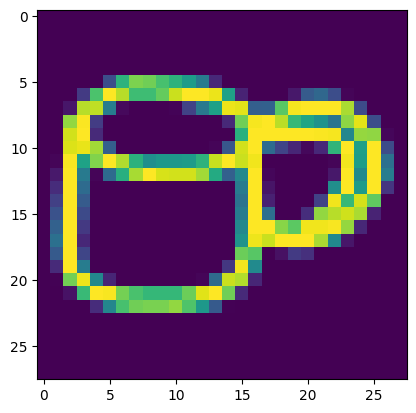

In [38]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28))
print(class_names[int(y_train[idx].item())])

# Preprocess the Data

In [39]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# The Model

In [40]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='tanh'))
model.add(layers.Dense(3, activation='softmax'))
# Train model
adam = tf.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 64)          0

# Training

In [42]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)

Epoch 1/5
34/34 - 0s - loss: 0.1229 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1499 - val_top_k_categorical_accuracy: 1.0000 - 301ms/epoch - 9ms/step
Epoch 2/5
34/34 - 0s - loss: 0.1113 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1703 - val_top_k_categorical_accuracy: 1.0000 - 217ms/epoch - 6ms/step
Epoch 3/5
34/34 - 0s - loss: 0.0978 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1355 - val_top_k_categorical_accuracy: 1.0000 - 225ms/epoch - 7ms/step
Epoch 4/5
34/34 - 0s - loss: 0.0897 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1463 - val_top_k_categorical_accuracy: 1.0000 - 202ms/epoch - 6ms/step
Epoch 5/5
34/34 - 0s - loss: 0.0912 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1606 - val_top_k_categorical_accuracy: 1.0000 - 214ms/epoch - 6ms/step


# Plotting Accuracy and Loss

In [43]:
history = model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)

Epoch 1/5
34/34 - 0s - loss: 0.0748 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1434 - val_top_k_categorical_accuracy: 1.0000 - 287ms/epoch - 8ms/step
Epoch 2/5
34/34 - 0s - loss: 0.0650 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1747 - val_top_k_categorical_accuracy: 1.0000 - 231ms/epoch - 7ms/step
Epoch 3/5
34/34 - 0s - loss: 0.0574 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1579 - val_top_k_categorical_accuracy: 1.0000 - 220ms/epoch - 6ms/step
Epoch 4/5
34/34 - 0s - loss: 0.0533 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1435 - val_top_k_categorical_accuracy: 1.0000 - 205ms/epoch - 6ms/step
Epoch 5/5
34/34 - 0s - loss: 0.0433 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.1492 - val_top_k_categorical_accuracy: 1.0000 - 207ms/epoch - 6ms/step


In [44]:
print(history.history.keys())

dict_keys(['loss', 'top_k_categorical_accuracy', 'val_loss', 'val_top_k_categorical_accuracy'])


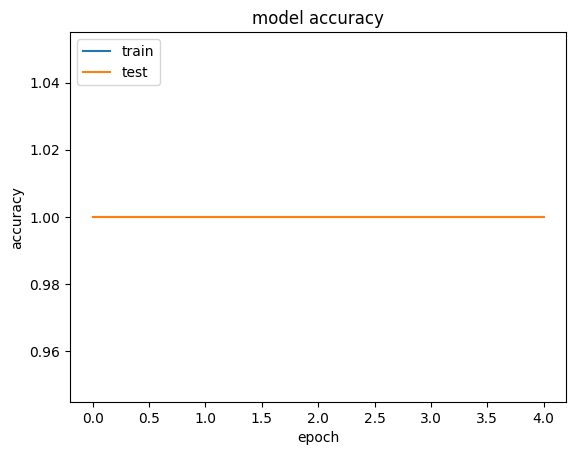

In [45]:
plt.plot(history.history['top_k_categorical_accuracy'])
plt.plot(history.history['val_top_k_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

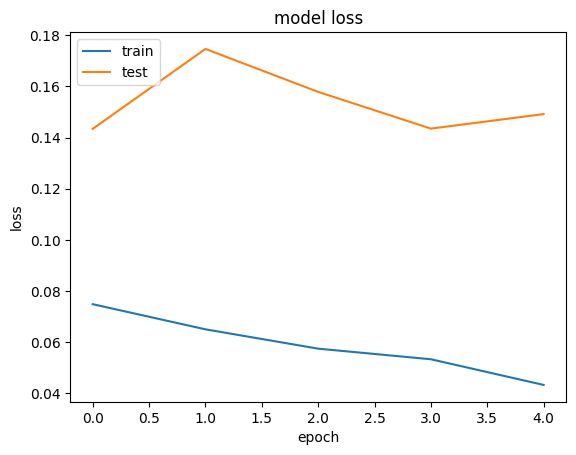

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Testing

In [47]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 100.00%


# Inference

1/1 [==============================] - 0s 29ms/step
['shovel', 'mug', 'passport']


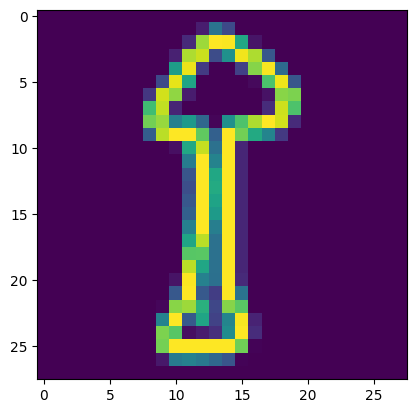

In [49]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze())
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

# Store the classes

In [50]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

# Install TensorFlowJS

In [51]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 42.9 MB/s eta 0:00:00


# Save and Convert

In [52]:
model.save('doodler.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [53]:
!mkdir model
!tensorflowjs_converter --input_format keras doodler.h5 model/

2023-11-09 04:40:04.556691: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-09 04:40:04.556753: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-09 04:40:04.556799: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-09 04:40:06.355023: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Zip and Download

In [54]:
!cp class_names.txt model/class_names.txt

In [55]:
!zip -r model.zip model

  adding: model/ (stored 0%)
  adding: model/group1-shard1of1.bin (deflated 8%)
  adding: model/class_names.txt (stored 0%)
  adding: model/model.json (deflated 82%)


In [56]:
from google.colab import files
files.download('model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>